**Bonus**

**mask on the scratch in the bad image**

In [21]:
# # Clone the compatible Mask R-CNN repository
# !git clone https://github.com/akTwelve/Mask_RCNN.git
# # Navigate to the Mask R-CNN directory and install it
# %cd Mask_RCNN
# !pip install .
# # Install dependencies for Mask R-CNN
# !pip install imgaug
# !pip install opencv-python
# !pip install matplotlib


In [22]:
# Verify TensorFlow and Mask R-CNN installation
import tensorflow as tf
from mrcnn import model as modellib

print("TensorFlow Version:", tf.__version__)
print("Mask R-CNN is ready to use!")


TensorFlow Version: 2.17.1
Mask R-CNN is ready to use!


**Step 1: Setup Environment and Libraries**

In [23]:
# Install required libraries
!pip install opencv-python-headless matplotlib

# Import libraries
import os
import numpy as np
import cv2
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt


**Step 2: Define the configuration for the Mask R-CNN model.**

In [24]:
class ScratchConfig(Config):
    NAME = "scratch_detection"  # Name of the model
    NUM_CLASSES = 1 + 1         # Background + Scratch
    GPU_COUNT = 1               # Number of GPUs to use
    IMAGES_PER_GPU = 1          # Images per GPU
    DETECTION_MIN_CONFIDENCE = 0.5  # Confidence threshold
    STEPS_PER_EPOCH = 100       # Training steps per epoch
    IMAGE_MIN_DIM = 224         # Minimum dimension of images
    IMAGE_MAX_DIM = 224         # Maximum dimension of images


**Step 3: Create Dataset Class to handle images and masks**

In [25]:
class ScratchDataset(utils.Dataset):
    def load_scratch(self, bad_dir, mask_dir):
        """
        Load bad images and their corresponding masks.
        """
        self.add_class("scratch_detection", 1, "scratch")  # Add scratch class

        # Add images
        bad_images = [f for f in os.listdir(bad_dir) if f.endswith('.png')]
        for idx, image_name in enumerate(bad_images):
            bad_image_path = os.path.join(bad_dir, image_name)
            mask_image_path = os.path.join(mask_dir, image_name)  # Assumes mask names match bad image names
            self.add_image("scratch_detection",
                           image_id=idx,
                           path=bad_image_path,
                           mask_path=mask_image_path)

    def load_mask(self, image_id):
        """
        Load masks for the given image ID.
        """
        info = self.image_info[image_id]
        mask_image = cv2.imread(info['mask_path'], cv2.IMREAD_GRAYSCALE)
        mask_image = cv2.resize(mask_image, (224, 224))  # Resize for consistency
        mask = np.expand_dims(mask_image, axis=-1)  # Add channel dimension
        mask = (mask > 128).astype(np.uint8)  # Binarize the mask
        class_ids = np.array([1])  # Scratch class ID
        return mask, class_ids

    def image_reference(self, image_id):
        """
        Return the path of the image.
        """
        return self.image_info[image_id]['path']


**Step 4: Load the dataset using the ScratchDataset class**

In [26]:
# Directories for bad images and masks
bad_dir = "/content/drive/MyDrive/Intern_job/anomaly_detection_test_data/bad"
mask_dir = "/content/drive/MyDrive/Intern_job/anomaly_detection_test_data/masks"

# Initialize and prepare dataset
dataset = ScratchDataset()
dataset.load_scratch(bad_dir, mask_dir)
dataset.prepare()

# Verify dataset
print("Dataset loaded:")
print(f"Total images: {len(dataset.image_ids)}")


Dataset loaded:
Total images: 1023


**Step 5: Visualize one image and its mask for verification**

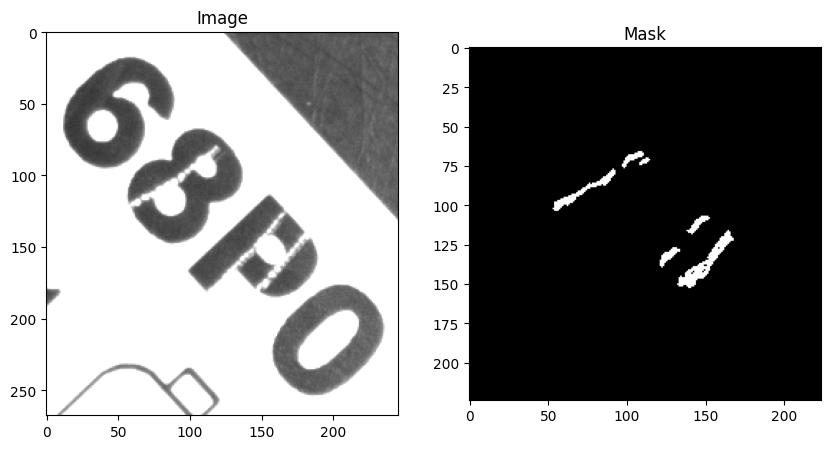

In [27]:
# Load one sample image and its mask
image_id = 10
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask[:, :, 0], cmap='gray')
plt.show()


**implement the threshold part for classifying an image as "bad" based on the size of the scratch**

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


**list all the image files in both the "bad" image folder and the "mask" image folder**

**Match bad images with corresponding masks**

**Load a bad image and its corresponding mask**

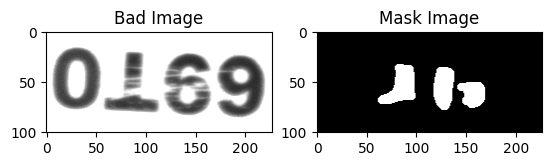

In [28]:
# Define paths to the bad images and mask images directories
bad_image_dir = '/content/drive/MyDrive/Intern_job/anomaly_detection_test_data/bad'
mask_image_dir = '/content/drive/MyDrive/Intern_job/anomaly_detection_test_data/masks'

# List all bad image filenames
bad_image_filenames = sorted([f for f in os.listdir(bad_image_dir) if f.endswith('.png')])

# List all mask image filenames (they should be the same as the bad image filenames)
mask_image_filenames = sorted([f for f in os.listdir(mask_image_dir) if f.endswith('.png')])

# Check that the filenames match
assert bad_image_filenames == mask_image_filenames, "Filenames do not match!"

# Example for loading the first bad image and corresponding mask
image_filename = bad_image_filenames[1]

# Paths to the bad image and mask
bad_image_path = os.path.join(bad_image_dir, image_filename)
mask_image_path = os.path.join(mask_image_dir, image_filename)

# Load the images
bad_image = cv2.imread(bad_image_path, cv2.IMREAD_COLOR)
mask_image = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)

# Visualize the bad image and mask
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(bad_image, cv2.COLOR_BGR2RGB))
plt.title("Bad Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_image, cmap='gray')
plt.title("Mask Image")

plt.show()


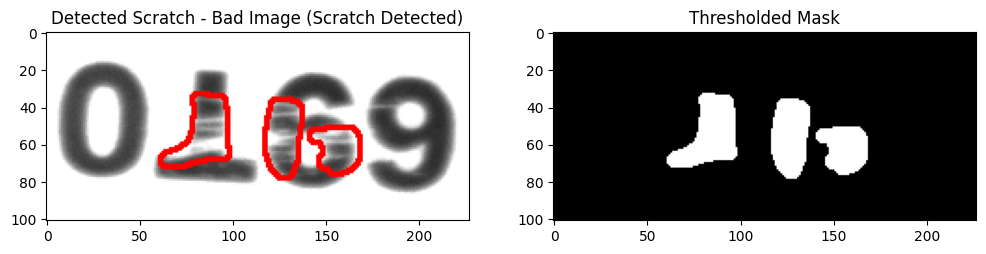

Bad Image (Scratch Detected)
Scratch Area: 2017.5 pixels


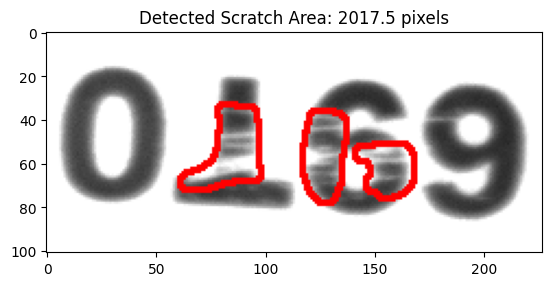

In [29]:
import cv2
import matplotlib.pyplot as plt

# Threshold the mask to identify the scratched regions
_, thresholded_mask = cv2.threshold(mask_image, 127, 255, cv2.THRESH_BINARY)

# Find contours in the mask
contours, _ = cv2.findContours(thresholded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the scratch area
scratch_area = sum([cv2.contourArea(contour) for contour in contours])

# Define a threshold value for classification
threshold_value = 500  # Example threshold in pixels

# Classify the image as "bad" or "good" based on the scratch area
if scratch_area > threshold_value:
    classification = "Bad Image (Scratch Detected)"
    color = (0, 0, 255)  # Red for bad image
else:
    classification = "Good Image (No significant scratch)"
    color = (0, 255, 0)  # Green for good image

# Draw the contours on the original image
image_with_contours = bad_image.copy()
cv2.drawContours(image_with_contours, contours, -1, color, 2)

# Visualize the results
plt.figure(figsize=(12, 6))

# Show the original image with detected scratch
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Scratch - {classification}")

# Show the thresholded mask
plt.subplot(1, 2, 2)
plt.imshow(thresholded_mask, cmap='gray')
plt.title("Thresholded Mask")

plt.show()

# Print the classification result
print(classification)

print(f"Scratch Area: {scratch_area} pixels")
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Scratch Area: {scratch_area} pixels")
plt.show()



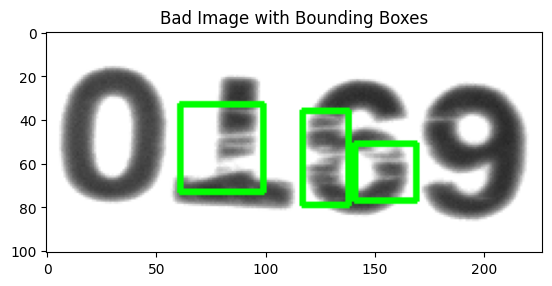

In [30]:
# Draw bounding boxes around the detected scratches
output_image = bad_image.copy()

for contour in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw a rectangle around the scratch
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show the image with bounding boxes
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Bad Image with Bounding Boxes")
plt.show()
